In [2]:
import import_ipynb
from Spaceship_Titanic_P2 import *

# Preprocessing

### Split data back into train and test sets

In [3]:
# Train and test
X = data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test = data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

### Drop unwanted features

In [4]:
# Drop qualitative/redundant/collinear/high cardinality features
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

### Log transform
- The logarithm transform is used to decrease skew in distributions, especially with large outliers.
- It can make it easier for algorithms to 'learn' the correct relationships. 

**We will apply it to the expenditure features as these are heavily skewed by outliers.**

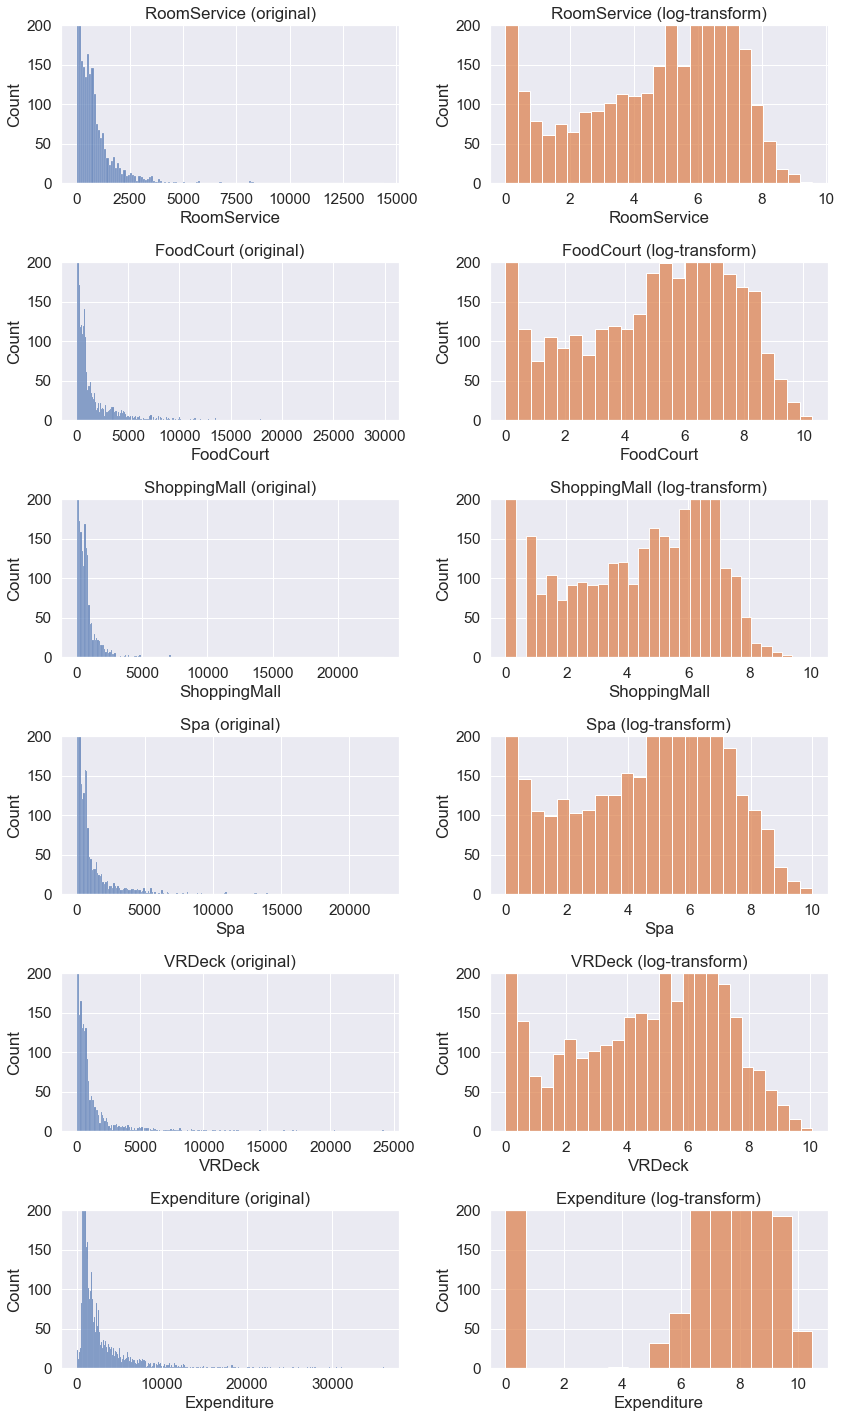

In [5]:
# Plot log transform results
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

### Apply log transform


In [6]:
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

### Encoding and scaling
- We will use column transformers to be more professional.

In [7]:
# Indentify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

In [8]:
# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

In [9]:
# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.transform(X_test)


In [10]:
# Print new shape
print('Training set shape:', X.shape)

Training set shape: (8693, 36)


### Create a validation set
- We will use this to choose which model(s) to use.

In [14]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

# Define classifiers
- Logistic Regression
- K-Nearest Neighbors
- Support Vector Machine
- Random Forest
- Extreme Gradient Boosting
- Light Gradient Boosting Machine
- Categorical Boosting
- Naive Bayes

In [17]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    #"SVC" : SVC(random_state=0, probability=True), # too long
    "RandomForest" : RandomForestClassifier(random_state=0),
    #"XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    #"CatBoost" : CatBoostClassifier(random_state=0, verbose=False), # too long
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

## Train and evaluate models
- Train models with grid search (but no cross validation so it doesn't take too long) to get a rough idea of which are the best models for this dataset.

In [18]:
i=0
clf_best_params = classifiers.copy()

valid_scores = pd.DataFrame({'Classifer':classifiers.keys(),
                           'Validation accuracy': np.zeros(len(classifiers)),
                           'Training time': np.zeros(len(classifiers))})

for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

Model: LogisticRegression
Training time (mins): 0.16

Model: KNN
Training time (mins): 0.05

Model: RandomForest
Training time (mins): 0.7

Model: LGBM
Training time (mins): 0.22

Model: NaiveBayes
Training time (mins): 0.0



In [19]:
# Show results
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.774008,0.16
1,KNN,0.757332,0.05
2,RandomForest,0.787234,0.70
3,LGBM,0.798735,0.22
4,NaiveBayes,0.718229,0.00


**Motivated by this, we will take LGBM and RandomForest to the final stage of modelling.**

## Modelling
- We can finally train our best model on the whole training set using cross validation and ensembling predictions together to produce the most confident predictions.

#### Define best models

In [22]:
# Classifiers
best_classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    "RandomFores" : RandomForestClassifier(**clf_best_params["RandomForest"], random_state=0),
   # "CatBoost" : CatBoostClassifier(**clf_best_params["CatBoost"], verbose=False, random_state=0),
}

## Cross validation and ensembling predictions
- Predictions are ensembled together using soft voting. 
- This averages the predicted probabilies to produce the most confident predictions.

In [23]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(X_test)[:,1]
        score += clf.score(X_valid, y_valid)

    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

Model: LGBM
Average validation accuracy: 81.12
Training time (mins): 0.06

Model: RandomFores
Average validation accuracy: 80.61
Training time (mins): 0.72



### Submission
- Let's look at the distribution of the predicted probabilities.

Text(0.5, 0, 'Probability')

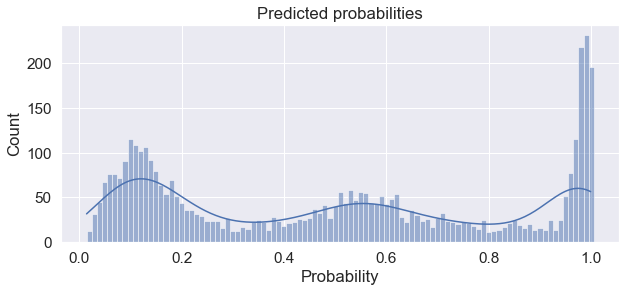

In [24]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

### Post processing
- Finally, we need to convert each predicted probability into one of the two classes (transported or not). 
- The simplest way is to round each probability to the nearest integer (0 for False or 1 for True). 



- However, assuming the train and test sets have similar distributions, we can tune the classification threshold to obtain a similar proportion of transported/not transported in our predictions as in the train set.

- Remember that the proportion of transported passengers in the train set was 50.4%.

In [25]:
# Proportion (in test set) we get from rounding
print(np.round(100*np.round(preds).sum()/len(preds),2))

51.06


Our models seem to (potentially) overestimate the number of transported passengers in the test set. 
Let's try to bring that proportion down a bit.

Optimal threshold: 0.49


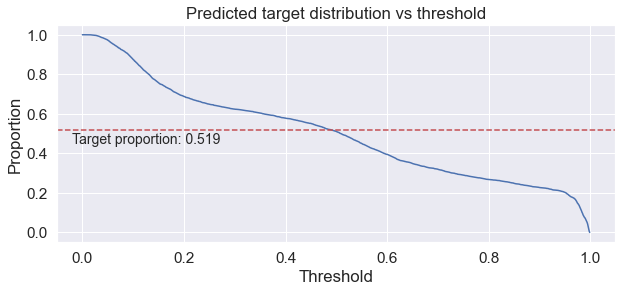

In [26]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    # Array of thresholds
    T_array=np.arange(0,1,0.001)
    
    # Calculate proportions
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    # Plot proportions
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.519         # Experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    
    # Find optimal threshold (the one that leads to the proportion being closest to target_prop)
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(preds)

In [28]:
# Classify test set using optimal threshold
preds_tuned=(preds>=T_opt).astype(int)

## Submit predictions

Text(0.5, 1.0, 'Prediction distribution')

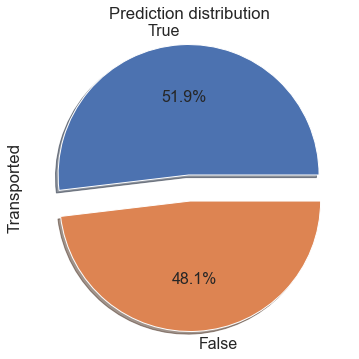

In [30]:
# Sample submission (to get right format)
sub=pd.read_csv('data/sample_submission.csv')

# Add predictions
sub['Transported']=preds_tuned

# Replace 0 to False and 1 to True
sub=sub.replace({0:False, 1:True})

# Prediction distribution
plt.figure(figsize=(6,6))
sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', 
                                           shadow=True, 
                                           textprops={'fontsize':16}).set_title("Prediction distribution")

In [31]:
# Output to csv
sub.to_csv('submission.csv', index=False)